**Loading Data and Checking Structure for Physics**

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 19 11:50:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              50W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

**Text Preprocessing and Dataset Loading**

In [2]:

# Import necessary libraries and modules

import pandas as pd # pandas (pd): A popular Python library for data manipulation and analysis. It's typically used for working with structured data like CSV files.
from sklearn.feature_extraction.text import TfidfVectorizer # TfidfVectorizer: Part of the sklearn.feature_extraction.text module, it is used to convert a collection of raw documents into a matrix of TF-IDF features.
import nltk # nltk: Stands for Natural Language Toolkit, a leading platform for building Python programs to work with human language data.
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize # stopwords & word_tokenize: Modules from nltk used to work with stop words and to tokenize text.
import string

# Function: Text Preprocessing
def text_preprocessor(input_text):
    """
    Preprocess the input text.

    Args:
        input_text (str): The text string to be processed.

    Returns:
        str: Processed text after tokenization, conversion to lower case,
             removal of punctuation, and filtering out non-alphabetic words and stopwords.
    """

    # Tokenization
    tokens = word_tokenize(input_text)# To separate the input text into individual words (tokens) by using the 'word_tokenize' function from NLTK
    # Convert to lower case, lower_tokens save all the words that were transformed to lowercase.
    lower_tokens = [w.lower() for w in tokens]# for w in tokens: This checks over each element in the list tokens. Each element is temporarily named w during each iteration.
                                              # w.lower(): For each element w, the .lower() method is called. .lower() is a string method in Python that converts all characters in the string to lowercase.
    # Removing punctuation
    punctuation_remover = str.maketrans('', '', string.punctuation)
    tokens_no_punctuation = [w.translate(punctuation_remover) for w in lower_tokens]
    # Filtering out non-alphabetic tokens and stop words
    stop_words_set = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens_no_punctuation if word.isalpha() and not word in stop_words_set]
    # Joining the filtered tokens back into a string
    return ' '.join(filtered_tokens)

# Function: Load and Preprocess Dataset
def load_and_preprocess_dataset(file_path):
    """
    Load and preprocess the dataset from the given file path.

    Args:
        file_path (str): Path to the dataset file.

    Returns:
        DataFrame: A pandas DataFrame containing the preprocessed dataset.
    """
    # Loading dataset using pandas
    dataset = pd.read_csv(file_path)
    # Applying text preprocessing to the 'abstract' column and storing the results in a new column
    dataset['processed_abstract'] = dataset['abstract'].apply(text_preprocessor)
    return dataset

# Downloading necessary NLTK data
nltk.download('punkt') # Downloading punkt tokenizer models
nltk.download('stopwords') # Downloading stopwords list

# Loading and preprocessing each dataset
physics_dataset = load_and_preprocess_dataset('./physics_abstracts.csv') # Processing physics abstracts
math_dataset = load_and_preprocess_dataset('./math_abstracts.csv') # Processing math abstracts
econ_dataset = load_and_preprocess_dataset('./econ_abstracts.csv')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Function to display original and processed abstracts from a dataset
def display_original_and_processed(dataset, num_samples=5):
    """
    Display the original and processed abstracts from the dataset.

    Args:
        dataset (DataFrame): A pandas DataFrame containing the dataset.
        num_samples (int, optional): The number of samples to display. Default is 5.
    """
    # Display the specified number of 'abstract' and 'processed_abstract' columns from the dataset
    display(dataset[['abstract', 'processed_abstract']].head(num_samples))

# Displaying original and processed abstracts for the Physics Dataset
print("Physics Dataset:")
display_original_and_processed(physics_dataset)

# Displaying original and processed abstracts for the Math Dataset
print("\nMath Dataset:")
display_original_and_processed(math_dataset)

# Displaying original and processed abstracts for the Economics Dataset
print("\nEconomics Dataset:")
display_original_and_processed(econ_dataset)


Physics Dataset:


,abstract,processed_abstract
0,In 1926 Albert Einstein gave a clear explanati...,albert einstein gave clear explanation physica...
1,For several decades a portrait of Johannes Kep...,several decades portrait johannes kepler widel...
2,Scientific education and divulgation not only ...,scientific education divulgation amplify peopl...
3,Using the Gaussian-03 for ab initio calculatio...,using ab initio calculations studied interacti...
4,We analyze retrospectively/prospectively the t...,analyze retrospectivelyprospectively transient...



Math Dataset:


,abstract,processed_abstract
0,The purpose of this contribution is to give a ...,purpose contribution give coherent account par...
1,Spectrum constructions appear throughout mathe...,spectrum constructions appear throughout mathe...
2,"A lattice L is coordinatizable, if it is isomo...",lattice l coordinatizable isomorphic lattice l...
3,This is an expository paper in which I explain...,expository paper explain core mathematics part...
4,This paper provides a conceptual study of the ...,paper provides conceptual study twisting proce...



Economics Dataset:


,abstract,processed_abstract
0,Models of social learning feature either binar...,models social learning feature either binary s...
1,This paper derives conditions under which pref...,paper derives conditions preferences technolog...
2,To determine the welfare implications of price...,determine welfare implications price changes d...
3,Consider a predictor who ranks eventualities o...,consider predictor ranks eventualities basis p...
4,Timing decisions are common: when to file your...,timing decisions common file taxes finish refe...


**Data Preparation and Feature Extraction for Text Classification**

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Function: Merge datasets and split into training and testing sets
def split_datasets(*datasets, test_size=0.2, random_state=42):
    """
    Merge datasets and split them into training and testing sets.

    Args:
        *datasets: A variable number of tuples, each containing a dataset (DataFrame) and its corresponding label (str).
        test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
        random_state (int, optional): Controls the shuffling applied to the data before applying the split. Default is 42.

    Returns:
        Tuple: Returns four elements - training data, testing data, training labels, and testing labels.
    """
    all_abstracts = [] # List to store all abstracts
    labels = [] # List to store all labels
    for dataset, label in datasets:
        all_abstracts += dataset['processed_abstract'].tolist() # Add abstracts from each dataset
        labels += [label] * len(dataset) # Add corresponding labels
    # Split the data and labels into training and testing sets
    return train_test_split(all_abstracts, labels, test_size=test_size, random_state=random_state)

# Function: Apply TF-IDF Vectorization
def apply_tfidf_vectorization(train_data, test_data):
    """
    Apply TF-IDF vectorization to the training and testing data.

    Args:
        train_data: List of training data abstracts.
        test_data: List of testing data abstracts.

    Returns:
        Tuple: The vectorizer, TF-IDF vectorized training data, and TF-IDF vectorized testing data.
    """
    vectorizer = TfidfVectorizer() # Creating a TfidfVectorizer object
    X_train = vectorizer.fit_transform(train_data) # Fit and transform the training data
    X_test = vectorizer.transform(test_data) # Transform the testing data
    return vectorizer, X_train, X_test

# Merging datasets and splitting
abstracts_train, abstracts_test, labels_train, labels_test = split_datasets(
    (physics_dataset, 'physics'),
    (math_dataset, 'math'),
    (econ_dataset, 'econ')
)

# Applying TF-IDF vectorization and getting the vectorizer
vectorizer, X_train_tfidf, X_test_tfidf = apply_tfidf_vectorization(abstracts_train, abstracts_test)


In [5]:
# Merging datasets and adding labels
all_data = pd.concat([
    physics_dataset.assign(label='physics'),  # Add 'physics' label to each entry in the physics_dataset
    math_dataset.assign(label='math'),        # Add 'math' label to each entry in the math_dataset
    econ_dataset.assign(label='econ')         # Add 'econ' label to each entry in the econ_dataset
])

# Displaying a sample of the combined dataset with labels
print("Combined Dataset with Labels:")
display(all_data[['processed_abstract', 'label']].sample(5, random_state=42))  # Displaying a random sample of 5 entries


Combined Dataset with Labels:


,processed_abstract,label
70,benchmark study carried groundstate potential ...,physics
227,paper characterizes informational outcomes mod...,econ
231,gentle introductory course quantum mechanics a...,physics
288,define notion colimit diagrams motivic categor...,math
39,century observing deflection light emitted dis...,physics


**BERT Model Preparation and Dataset Setup for Text Classification**

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Function to load BERT model and tokenizer
def load_bert_model_and_tokenizer(num_labels=3):
    """
    Load a BERT model and tokenizer.

    Args:
        num_labels (int): The number of labels for sequence classification.

    Returns:
        Tuple: BERT tokenizer and model.
    """
    # Loading BERT tokenizer and model for sequence classification
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

    # Freezing all layers except the last 4 layers
    for name, param in model.named_parameters():
        parts = name.split('.')
        if len(parts) > 2 and parts[1] == 'layer':
            layer_num = int(parts[2])
            if layer_num < 8:
                param.requires_grad = False

    return tokenizer, model



# Loading BERT model and tokenizer
tokenizer, bert_model = load_bert_model_and_tokenizer(num_labels=3)

# Checking which layers are unfrozen
for name, param in bert_model.named_parameters():
    if param.requires_grad:
        print(name)

# Function to encode text data
def encode_texts(tokenizer, texts):
    """
    Encode text data using the provided tokenizer.

    Args:
        tokenizer: The BERT tokenizer.
        texts (list of str): List of texts to be encoded.

    Returns:
        Encoded texts as per BERT's requirements.
    """
    return tokenizer(texts, truncation=True, padding=True, max_length=512)

# Converting labels to numeric values
label_to_index = {'physics': 0, 'math': 1, 'econ': 2}
y_train_encoded = [label_to_index[label] for label in labels_train]
y_test_encoded = [label_to_index[label] for label in labels_test]

# Encoding training and testing texts
train_encodings = encode_texts(tokenizer, abstracts_train)
test_encodings = encode_texts(tokenizer, abstracts_test)

# Class to create a BERT dataset
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# 创建数据集
train_dataset = BERTDataset(train_encodings, y_train_encoded)
test_dataset = BERTDataset(test_encodings, y_test_encoded)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [7]:
pip install transformers[torch]

In [8]:
pip install accelerate -U

BERT Model Training and Performance Evaluation with 5-Fold Cross-Validation and Metrics Visualization

In [9]:
from sklearn.model_selection import StratifiedKFold
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Function to plot training and validation losses
def plot_average_loss(training_losses, validation_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(training_losses[:10], label='Average Training Loss')
    plt.plot(validation_losses[:10], label='Average Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training and Validation Loss Over All Folds for BERT')
    plt.legend()
    plt.xlim(0, 10)
    plt.show()

# Initializing lists to accumulate predictions and true labels
all_preds = []
all_true_labels = []

# Initializing lists to accumulate training and validation losses
all_training_losses = []
all_validation_losses = []

# Function to compute evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Stratified K-Fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = []

# Modifying the text encoding function to accept indices
def encode_texts_with_indices(tokenizer, texts, indices):
    selected_texts = [texts[i] for i in indices]
    return tokenizer(selected_texts, truncation=True, padding=True, max_length=512)

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kfold.split(abstracts_train, labels_train)):
    print(f"Training on fold {fold + 1}")

    # Creating datasets for the current fold
    train_encodings_fold = encode_texts_with_indices(tokenizer, abstracts_train, train_idx)
    val_encodings_fold = encode_texts_with_indices(tokenizer, abstracts_train, val_idx)
    train_dataset_fold = BERTDataset(train_encodings_fold, np.array(y_train_encoded)[train_idx])
    val_dataset_fold = BERTDataset(val_encodings_fold, np.array(y_train_encoded)[val_idx])

    # Setting up training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_fold_{fold}',
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        learning_rate=2e-5,
        logging_dir=f'./logs_fold_{fold}',
        logging_steps=10,
        evaluation_strategy="epoch"
    )

    # Initializing the Trainer
    trainer = Trainer(
        model=bert_model,
        args=training_args,
        train_dataset=train_dataset_fold,
        eval_dataset=val_dataset_fold,
        compute_metrics=compute_metrics
    )

    # Training the model for the current fold
    trainer.train()

    # Collecting training and validation losses for the current fold
    fold_training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
    fold_validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

    # Adding the losses from the current fold to the overall lists
    all_training_losses.append(fold_training_loss)
    all_validation_losses.append(fold_validation_loss)

    # Making predictions for the current fold
    predictions = trainer.predict(val_dataset_fold)
    preds = np.argmax(predictions.predictions, axis=1)
    true_labels = np.array(y_train_encoded)[val_idx]

    # Appending predictions and true labels to cumulative lists
    all_preds.extend(preds)
    all_true_labels.extend(true_labels)

    # Evaluating and recording results
    eval_results = trainer.evaluate()
    cross_val_results.append(eval_results)

# Printing average cross-validation results
avg_results = {metric: np.mean([result[metric] for result in cross_val_results]) for metric in cross_val_results[0]}
print("Average Cross-Validation Results:", avg_results)


Training on fold 1


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.164400,1.056659,0.395833,0.339768,0.601420,0.395833
2,0.926500,0.797520,0.750000,0.740693,0.785679,0.750000
3,0.637700,0.442319,0.979167,0.979164,0.979578,0.979167
4,0.265000,0.204628,0.979167,0.979300,0.980392,0.979167
5,0.163000,0.085756,1.000000,1.000000,1.000000,1.000000
6,0.052700,0.054566,0.986111,0.986031,0.986392,0.986111
7,0.014500,0.035345,0.993056,0.993053,0.993194,0.993056
8,0.014600,0.066998,0.986111,0.986099,0.986656,0.986111
9,0.019400,0.044882,0.986111,0.986099,0.986656,0.986111
10,0.003100,0.074215,0.986111,0.986099,0.986656,0.986111


Training on fold 2


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.002900,0.001965,1.000000,1.000000,1.000000,1.000000
2,0.002400,0.001592,1.000000,1.000000,1.000000,1.000000
3,0.001900,0.001150,1.000000,1.000000,1.000000,1.000000
4,0.001400,0.000825,1.000000,1.000000,1.000000,1.000000
5,0.000900,0.000570,1.000000,1.000000,1.000000,1.000000
6,0.000600,0.000408,1.000000,1.000000,1.000000,1.000000
7,0.000500,0.000301,1.000000,1.000000,1.000000,1.000000
8,0.000400,0.000226,1.000000,1.000000,1.000000,1.000000
9,0.000300,0.000175,1.000000,1.000000,1.000000,1.000000
10,0.000200,0.000137,1.000000,1.000000,1.000000,1.000000


Training on fold 3


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000200,0.000124,1.000000,1.000000,1.000000,1.000000
2,0.000200,0.000097,1.000000,1.000000,1.000000,1.000000
3,0.000100,0.000069,1.000000,1.000000,1.000000,1.000000
4,0.000100,0.000048,1.000000,1.000000,1.000000,1.000000
5,0.000100,0.000037,1.000000,1.000000,1.000000,1.000000
6,0.000100,0.000045,1.000000,1.000000,1.000000,1.000000
7,0.054500,0.000033,1.000000,1.000000,1.000000,1.000000
8,0.000100,0.029755,0.993056,0.993054,0.993194,0.993056
9,0.000000,0.000026,1.000000,1.000000,1.000000,1.000000
10,0.000000,0.000020,1.000000,1.000000,1.000000,1.000000


Training on fold 4


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000000,0.000015,1.000000,1.000000,1.000000,1.000000
2,0.000000,0.000012,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000009,1.000000,1.000000,1.000000,1.000000
4,0.000000,0.000007,1.000000,1.000000,1.000000,1.000000
5,0.000000,0.000005,1.000000,1.000000,1.000000,1.000000
6,0.000000,0.000004,1.000000,1.000000,1.000000,1.000000
7,0.000000,0.000003,1.000000,1.000000,1.000000,1.000000
8,0.000000,0.000002,1.000000,1.000000,1.000000,1.000000
9,0.000000,0.000002,1.000000,1.000000,1.000000,1.000000
10,0.000000,0.000001,1.000000,1.000000,1.000000,1.000000


Training on fold 5


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000000,0.000001,1.000000,1.000000,1.000000,1.000000
2,0.000000,0.000001,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000001,1.000000,1.000000,1.000000,1.000000
4,0.000000,0.000001,1.000000,1.000000,1.000000,1.000000
5,0.000000,0.000001,1.000000,1.000000,1.000000,1.000000
6,0.000000,0.000001,1.000000,1.000000,1.000000,1.000000
7,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
8,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
9,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
10,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


Average Cross-Validation Results: {'eval_loss': 0.014874737461599351, 'eval_accuracy': 0.9972222222222221, 'eval_f1': 0.9972198067632849, 'eval_precision': 0.9973311546840957, 'eval_recall': 0.9972222222222221, 'eval_runtime': 0.48957999999999996, 'eval_samples_per_second': 296.15919999999994, 'eval_steps_per_second': 6.17, 'epoch': 10.0}


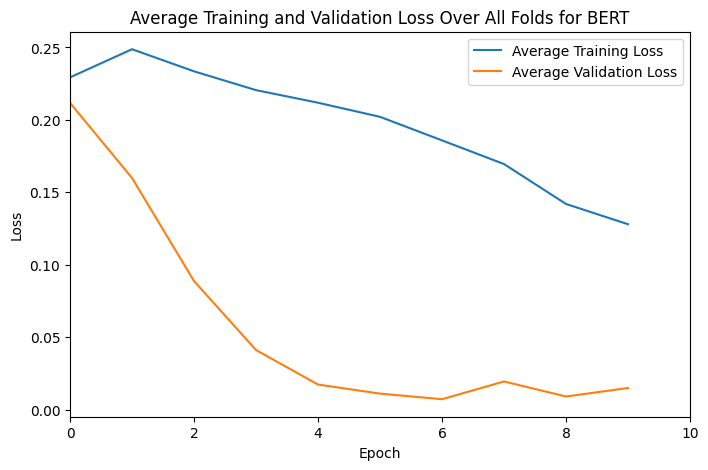

In [10]:
# After completing all folds, calculate the average loss for each epoch
average_training_losses = np.mean(all_training_losses, axis=0)
average_validation_losses = np.mean(all_validation_losses, axis=0)

# Plot the average loss graph
plot_average_loss(average_training_losses, average_validation_losses)


Evaluation results on test set: {'eval_loss': 0.33139923214912415, 'eval_accuracy': 0.9777777777777777, 'eval_f1': 0.9777236835304456, 'eval_precision': 0.9783056002862766, 'eval_recall': 0.9777777777777777, 'eval_runtime': 0.5204, 'eval_samples_per_second': 345.879, 'eval_steps_per_second': 5.765, 'epoch': 10.0}
Classification Report for BERT:
              precision    recall  f1-score   support

     Physics       1.00      1.00      1.00       240
        Math       1.00      0.99      1.00       233
   Economics       0.99      1.00      1.00       247

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



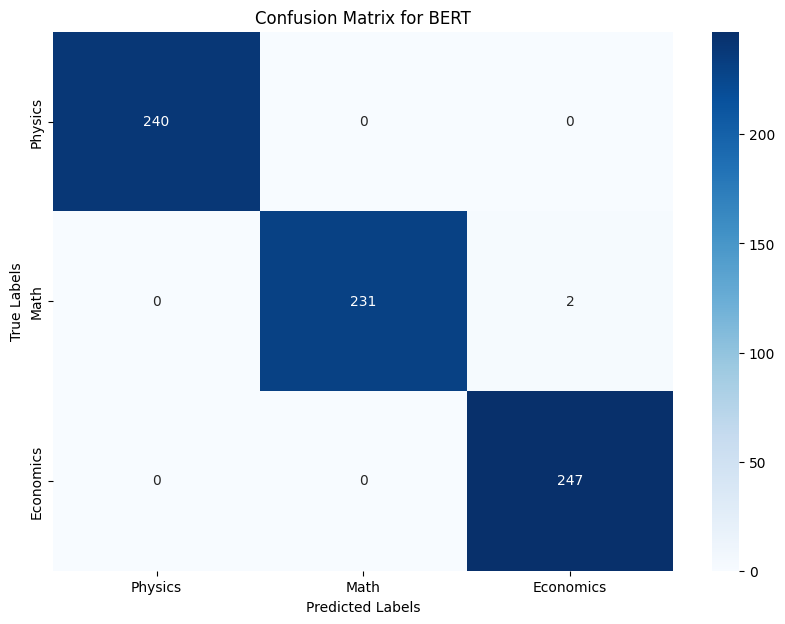

Model saved to ./saved_model


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot a confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plot a confusion matrix using Seaborn's heatmap.

    Args:
        conf_matrix: The confusion matrix to plot.
        class_names (list of str): Names of the classes.
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for BERT')
    plt.show()

# Ensure a list containing all class names
class_labels = ['Physics', 'Math', 'Economics']

# Evaluate the model on the test dataset using the Trainer object
evaluation_results = trainer.evaluate(test_dataset)
print("Evaluation results on test set:", evaluation_results)

# After all folds are completed, calculate the overall classification report and confusion matrix
overall_classification_report = classification_report(all_true_labels, all_preds, target_names=class_labels)
overall_confusion_matrix = confusion_matrix(all_true_labels, all_preds)

# Print the overall classification report
print("Classification Report for BERT:")
print(overall_classification_report)

# Plot the overall confusion matrix
plot_confusion_matrix(overall_confusion_matrix, class_labels)

# Save the model and tokenizer
model_path = "./saved_model"
tokenizer.save_pretrained(model_path)
bert_model.save_pretrained(model_path)
print("Model saved to", model_path)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Function to train a logistic regression model
def train_logistic_regression(X_train, y_train):
    """
    Train a logistic regression model on the provided training data.

    Args:
        X_train: The input features for training (TF-IDF vectors in this context).
        y_train: The target labels for training.

    Returns:
        The trained logistic regression model.
    """
    model = LogisticRegression(max_iter=1000)  # Initializing the Logistic Regression model with a high number of iterations
    model.fit(X_train, y_train)  # Fitting the model to the training data
    return model

# Training the logistic regression model
logistic_model = train_logistic_regression(X_train_tfidf, labels_train)  # Using the TF-IDF transformed training data and labels


Average Performance across all folds:
Accuracy: 0.9722222222222223
Precision: 0.9735567863587897
Recall: 0.9722222222222223
F1 Score: 0.9722716458703713

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

     Physics       1.00      0.96      0.98       247
        Math       0.99      0.96      0.97       233
   Economics       0.94      1.00      0.97       240

    accuracy                           0.97       720
   macro avg       0.97      0.97      0.97       720
weighted avg       0.97      0.97      0.97       720



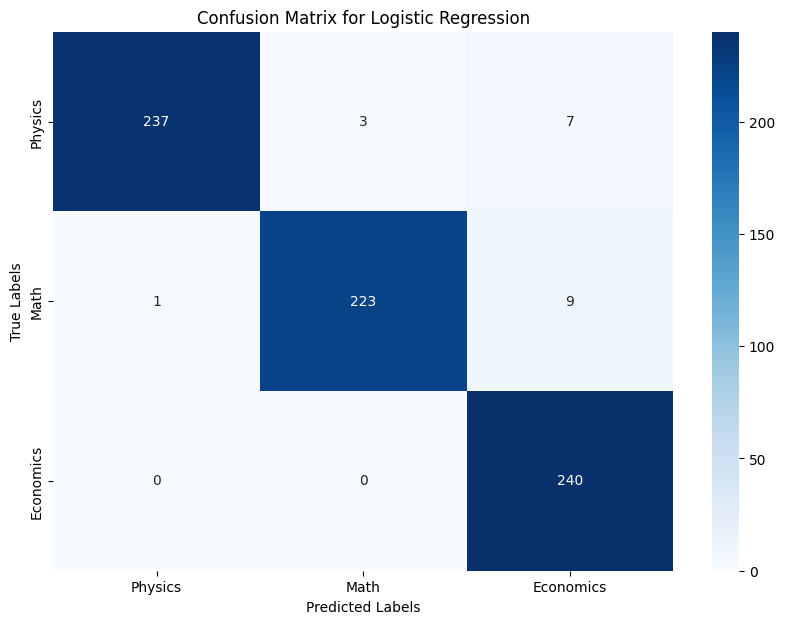

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression

all_y_pred = []
all_y_true = []

# Setting K-Fold parameters
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Preparing data for K-Fold
X = X_train_tfidf
y = np.array(labels_train)

# Storing performance metrics for each fold
fold_performance = []

# K-Fold Cross-Validation
for train_index, val_index in skf.split(X, y):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Train Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_fold, y_train_fold)

    # Predict on the validation set
    y_pred = model.predict(X_val_fold)

    # Calculate and store performance metrics
    accuracy = accuracy_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred, average='weighted')
    recall = recall_score(y_val_fold, y_pred, average='weighted')
    f1 = f1_score(y_val_fold, y_pred, average='weighted')

    fold_performance.append({
        'fold': len(fold_performance) + 1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

    # Add predictions and true labels to lists
    all_y_pred.extend(y_pred)
    all_y_true.extend(y_val_fold)

# Function to plot a confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Logistic Regression')
    plt.show()

# Calculate average performance metrics
avg_accuracy = sum([fp['accuracy'] for fp in fold_performance]) / n_splits
avg_precision = sum([fp['precision'] for fp in fold_performance]) / n_splits
avg_recall = sum([fp['recall'] for fp in fold_performance]) / n_splits
avg_f1_score = sum([fp['f1_score'] for fp in fold_performance]) / n_splits

print("Average Performance across all folds:")
print(f"Accuracy: {avg_accuracy}")
print(f"Precision: {avg_precision}")
print(f"Recall: {avg_recall}")
print(f"F1 Score: {avg_f1_score}")

# Calculate overall classification report
print("\nClassification Report for Logistic Regression:")
print(classification_report(all_y_true, all_y_pred, target_names=class_labels))

# Calculate overall confusion matrix
conf_matrix_lr = confusion_matrix(all_y_true, all_y_pred)
plot_confusion_matrix(conf_matrix_lr, class_labels)


In [14]:
from IPython.display import display
import pandas as pd
import numpy as np

# Creating a dictionary for BERT results after K-Fold cross-validation
bert_results = {
    'Model': 'BERT',
    'Accuracy': np.mean([result['eval_accuracy'] for result in cross_val_results]),
    'Precision': np.mean([result['eval_precision'] for result in cross_val_results]),
    'Recall': np.mean([result['eval_recall'] for result in cross_val_results]),
    'F1 Score': np.mean([result['eval_f1'] for result in cross_val_results])
}

# Creating a dictionary for Logistic Regression results after K-Fold cross-validation
logistic_results = {
    'Model': 'Logistic Regression',
    'Accuracy': avg_accuracy,
    'Precision': avg_precision,
    'Recall': avg_recall,
    'F1 Score': avg_f1_score
}

# Creating a DataFrame from the dictionaries
kfold_df = pd.DataFrame([bert_results, logistic_results])

# Displaying the DataFrame using the display function for a nicely formatted table
display(kfold_df)


,Model,Accuracy,Precision,Recall,F1 Score
0,BERT,0.997222,0.997331,0.997222,0.997220
1,Logistic Regression,0.972222,0.973557,0.972222,0.972272


In [17]:
from transformers import Trainer
import numpy as np

index_to_label = {0: 'physics', 1: 'math', 2: 'econ'}

def predict_abstract(abstract, bert_model, logistic_model, tokenizer, vectorizer, trainer):
    """
    Predict the classification of an abstract using both BERT and Logistic Regression models.

    Args:
        abstract (str): The text of the abstract to be classified.
        bert_model: The pre-trained BERT model.
        logistic_model: The trained Logistic Regression model.
        tokenizer: The tokenizer for BERT.
        vectorizer: The TF-IDF vectorizer for Logistic Regression.
        trainer: The Trainer object for BERT model predictions.

    Returns:
        tuple: The predicted labels from the BERT model and the Logistic Regression model.
    """
    # Preprocessing the abstract
    processed_abstract = text_preprocessor(abstract)

    # BERT Encoding
    bert_encoded = encode_texts(tokenizer, [processed_abstract])
    bert_dataset = BERTDataset(bert_encoded)

    # Predicting with BERT model using Trainer
    bert_pred_output = trainer.predict(bert_dataset)
    bert_label_index = np.argmax(bert_pred_output.predictions, axis=1)[0]
    bert_label = index_to_label[bert_label_index]

    # TF-IDF Vectorization and Logistic Regression Prediction
    tfidf_encoded = vectorizer.transform([processed_abstract])
    logistic_label = logistic_model.predict(tfidf_encoded)[0]

    return bert_label, logistic_label


In [16]:
# 手动输入摘要
input_abstract = "Electrophotography is one means of arranging 100 million pigmented plastic particles on a sheet of paper to faithfully replicate an original. It is based on many diverse phenomena and employs many properties of matter. These include gaseous ionization in the charging step; photogeneration and charge transport through disordered solid-state materials in the latent-image-formation step; triboelectricity in the particle-charging step; mechanical, electrostatic, and magnetic forces to detach particles in the development and transfer steps; and the application and transfer of heat in the fixing step. In addition, it relies on a precise balance of thermorheological, chemical, and mechanical properties of large area films and small particles. This article reviews the physics of the latent-image formation and development steps."

# 传递之前创建的Trainer实例给predict_abstract函数
bert_label, logistic_label = predict_abstract(input_abstract, bert_model, logistic_model, tokenizer, vectorizer, trainer)

print(f"BERT Model Prediction: {bert_label}")
print(f"Logistic Regression Prediction: {logistic_label}")



BERT Model Prediction: physics
Logistic Regression Prediction: physics
